# Image Captioning Using CNN + LSTM

In [12]:
# import tensorflow as tf
# print("TensorFlow version:", tf.__version__)
# print("GPU available:", tf.config.list_physical_devices('GPU'))

## Loading Libraries

In [13]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

## Loading Dataset

In [14]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"cs2406022","key":"ab7b2c139c058cc400c6c1fb0796fd01"}'}

In [15]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [11]:
!kaggle datasets download -d adityajn105/flickr8k

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
flickr8k.zip: Skipping, found more recently modified local copy (use --force to force download)


In [16]:
!unzip flickr8k.zip -d /content/flickr8k

Streaming output truncated to the last 5000 lines.
  inflating: /content/flickr8k/Images/2844846111_8c1cbfc75d.jpg  
  inflating: /content/flickr8k/Images/2844963839_ff09cdb81f.jpg  
  inflating: /content/flickr8k/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: /content/flickr8k/Images/2845691057_d4ab89d889.jpg  
  inflating: /content/flickr8k/Images/2845845721_d0bc113ff7.jpg  
  inflating: /content/flickr8k/Images/2846037553_1a1de50709.jpg  
  inflating: /content/flickr8k/Images/2846785268_904c5fcf9f.jpg  
  inflating: /content/flickr8k/Images/2846843520_b0e6211478.jpg  
  inflating: /content/flickr8k/Images/2847514745_9a35493023.jpg  
  inflating: /content/flickr8k/Images/2847615962_c330bded6e.jpg  
  inflating: /content/flickr8k/Images/2847859796_4d9cb0d31f.jpg  
  inflating: /content/flickr8k/Images/2848266893_9693c66275.jpg  
  inflating: /content/flickr8k/Images/2848571082_26454cb981.jpg  
  inflating: /content/flickr8k/Images/2848895544_6d06210e9d.jpg  
  inflating: /content/fli

In [17]:
IMG_PATH = '/content/flickr8k/Images'
CAP_PATH = '/content/flickr8k/captions.txt'

In [18]:
data = pd.read_csv(CAP_PATH)
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


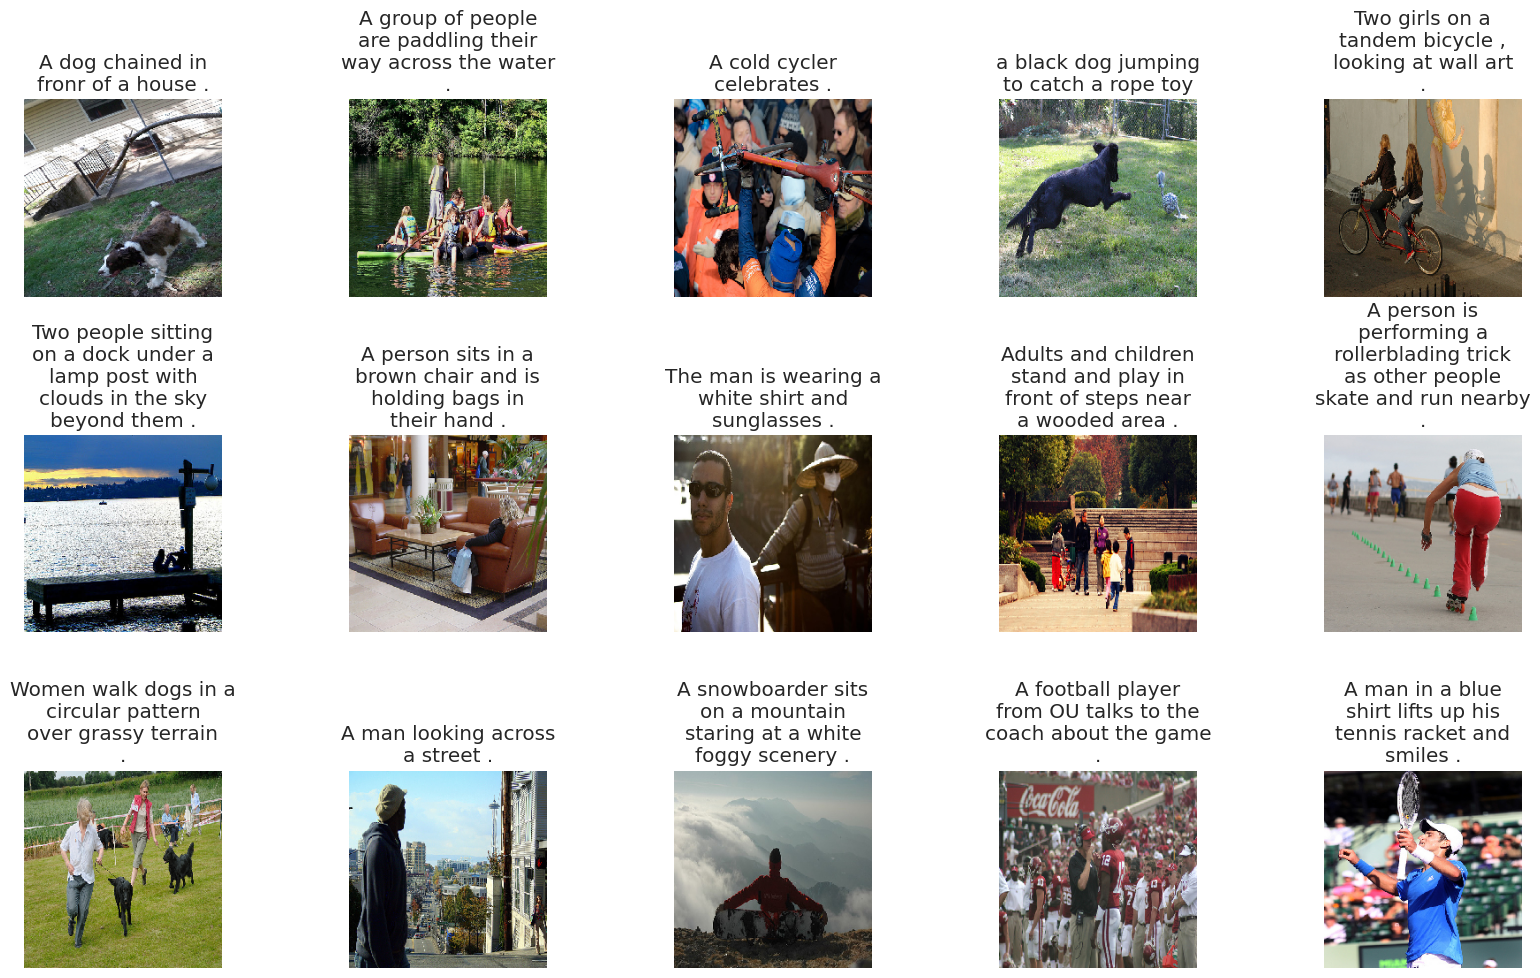

In [19]:
def readImage(path, img_size=224):
  img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
  img = img_to_array(img) / 255.0
  return img

def display_images(temp_df, sample_size=15):
  temp_df = temp_df.reset_index(drop=True)
  plt.figure(figsize=(20, 20))

  for n in range(sample_size):
      plt.subplot(5, 5, n+1)
      plt.subplots_adjust(hspace=0.7, wspace=0.3)

      img_path = os.path.join(IMG_PATH, temp_df.image[n])
      image = readImage(img_path)
      plt.imshow(image)
      plt.title("\n".join(wrap(temp_df.caption[n], 20)))
      plt.axis("off")

  plt.show()


display_images(data.sample(15))

## Text Preprocessing

In [20]:
import re

def text_preprocessing(data):
    # lowercase
    data['caption'] = data['caption'].apply(lambda x: x.lower())

    # remove everything except alphabets
    data['caption'] = data['caption'].apply(lambda x: re.sub(r'[^a-z]', ' ', x))

    # remove extra spaces
    data['caption'] = data['caption'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

    # remove single-character words
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word) > 1]))

    # add startseq and endseq tokens
    data['caption'] = data['caption'].apply(lambda x: "startseq " + x + " endseq")

    return data

# Apply preprocessing
data = text_preprocessing(data)

# Get list of captions
captions = data['caption'].tolist()
print(captions[:10])

['startseq child in pink dress is climbing up set of stairs in an entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in pink dress going into wooden cabin endseq', 'startseq black dog and spotted dog are fighting endseq', 'startseq black dog and tri colored dog playing with each other on the road endseq', 'startseq black dog and white dog with brown spots are staring at each other in the street endseq', 'startseq two dogs of different breeds looking at each other on the road endseq', 'startseq two dogs on pavement moving toward each other endseq']


## Tokenization and Encoded Representation

In [21]:
import random

# Tokenizer with <unk> for unseen words
tokenizer = Tokenizer(oov_token="<unk>")
tokenizer.fit_on_texts(captions)

vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

# Shuffle before splitting
images = data['image'].unique().tolist()
random.shuffle(images)
nimages = len(images)

split_index = round(0.85 * nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)].reset_index(drop=True)
test = data[data['image'].isin(val_images)].reset_index(drop=True)

In [22]:
# Example sequence
print(tokenizer.texts_to_sequences([captions[1]])[0])

[2, 19, 314, 64, 195, 117, 3]


## Image Feature Extraction Using CNN with Transfer Learning (DenseNet)

In [23]:
from tensorflow.keras.applications.densenet import preprocess_input

# Load DenseNet201 pretrained model
base_model = DenseNet201(weights="imagenet", include_top=False, pooling="avg")

img_size = 224
features = {}

for image in tqdm(data['image'].unique().tolist()):
    # Load and preprocess image
    img_path = os.path.join(IMG_PATH, image)
    img = load_img(img_path, target_size=(img_size, img_size))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)

    # Extract features
    feature = base_model.predict(img, verbose=0)
    features[image] = feature

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


100%|██████████| 8091/8091 [52:20<00:00,  2.58it/s]


## Data Generation

In [24]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y


train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=IMG_PATH,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=IMG_PATH,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [25]:
# checking one generated embedding
train_generator[0]

((array([[8.8064306e-05, 4.5896313e-04, 1.4732213e-03, ..., 2.4619511e-01,
          3.0888267e+00, 1.3367063e-01],
         [8.8064306e-05, 4.5896313e-04, 1.4732213e-03, ..., 2.4619511e-01,
          3.0888267e+00, 1.3367063e-01],
         [8.8064306e-05, 4.5896313e-04, 1.4732213e-03, ..., 2.4619511e-01,
          3.0888267e+00, 1.3367063e-01],
         ...,
         [6.3083993e-05, 9.7453501e-04, 9.2346023e-04, ..., 5.1005757e-01,
          9.2682427e-01, 4.2243540e-02],
         [6.3083993e-05, 9.7453501e-04, 9.2346023e-04, ..., 5.1005757e-01,
          9.2682427e-01, 4.2243540e-02],
         [6.3083993e-05, 9.7453501e-04, 9.2346023e-04, ..., 5.1005757e-01,
          9.2682427e-01, 4.2243540e-02]], dtype=float32),
  array([[  0,   0,   0, ...,   0,   0,   2],
         [  0,   0,   0, ...,   0,   2,  15],
         [  0,   0,   0, ...,   2,  15,   9],
         ...,
         [  0,   0,   0, ...,   4, 241,  46],
         [  0,   0,   0, ..., 241,  46, 125],
         [  0,   0,   0, ...,

## Modelling

In [ ]:
from tensorflow.keras.utils import plot_model

input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')


from tensorflow.keras.callbacks import ModelCheckpoint

# Define the model checkpoint
model_name = "model.keras"  # Update the extension to .keras
checkpoint = ModelCheckpoint(
    model_name,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 5.6662
Epoch 1: val_loss improved from inf to 4.25279, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 1061s 2s/step - loss: 5.6650 - val_loss: 4.2528 - learning_rate: 0.0010
Epoch 2/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 4.2984
Epoch 2: val_loss improved from 4.25279 to 3.93591, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 1042s 2s/step - loss: 4.2983 - val_loss: 3.9359 - learning_rate: 0.0010
Epoch 3/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 3.9885
Epoch 3: val_loss improved from 3.93591 to 3.78080, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 1036s 2s/step - loss: 3.9884 - val_loss: 3.7808 - learning_rate: 0.0010
Epoch 4/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 3.7938
Epoch 4: val_loss improved from 3.78080 to 3.69892, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 1040s 2s/step - loss: 3.7938 - val_loss: 3.6989 - learning_rate: 0.0010
Epoch 5/50
537/5

### Visualizing Learning

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss', fontsize=16)
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## Caption Generation

In [ ]:
import pickle

# Save the tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Save the feature extractor model
fe.save("feature_extractor.keras")

with open("features.pkl", "rb") as f:
    features = pickle.load(f)

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.densenet import preprocess_input
import matplotlib.pyplot as plt
import pickle


def generate_and_display_caption(IMG_PATH, model_path, tokenizer_path, feature_extractor_path, max_length=34, img_size=224):
    # Load trained models and tokenizer
    caption_model = load_model(model_path)
    feature_extractor = load_model(feature_extractor_path)

    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)

    # Preprocess the image for feature extraction
    img = load_img(IMG_PATH, target_size=(img_size, img_size))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    image_features = feature_extractor.predict(img, verbose=0)

    # Generate caption
    in_text = "startseq"
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([image_features, sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index, None)
        if word is None:
            break
        in_text += " " + word
        if word == "endseq":
            break

    caption = in_text.replace("startseq", "").replace("endseq", "").strip()
    caption = " ".join(caption.split())  # clean up spaces

    # Display image + caption
    img = load_img(IMG_PATH, target_size=(img_size, img_size))
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis("off")
    plt.title(caption, fontsize=16, color="blue")
    plt.show()


## Testing Model

In [ ]:
# import random
# import os

# List all images in the folder
all_images = os.listdir(IMG_PATH)

# Pick 5 random images
random_images = random.sample(all_images, 5)

# Generate captions for each
for img_name in random_images:
    img_path = os.path.join(img_folder, img_name)
    print(f"Image: {img_name}")
    generate_and_display_caption(img_path, model_path, tokenizer_path, feature_extractor_path)
